# KACA tutorial

In [1]:
##load all packages
import anndata
import collections
import numpy as np
import pandas as pd
import scanpy as sc
import KACA_ensemble as kaca_ensem

import warnings
warnings.filterwarnings("ignore")

In [2]:
##Baron Human pancreas data as example here
data_file   = "Documents/scRNAseq_Benchmark_datasets/Intra-dataset/Pancreatic_data/Baron_Human/Filtered_Baron_HumanPancreas_data.csv"
data = pd.read_csv(data_file,header=0,index_col=0)

##normalization
adata= anndata.AnnData(X=data)
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [3]:
##Use PanglaoDB as marker database
##PanglaoDB
pg_df = pd.read_table("PanglaoDB_markers_27_Mar_2020.tsv")
##remove mouse specific genes
pg_df = pg_df[pg_df['species']!='Mm']
cell_markers = {}##cell_marker is dictionary that contains names of cell types and their marker genes
marker_list = []
for i in list(set(pg_df["cell type"].values.tolist())):
    genes = pg_df[pg_df["cell type"]==i]['official gene symbol'].values.tolist()
    ##only use cell type with at least 5 genes and less than 300 genes
    if len(genes)>=5 and len(genes)<=300:
        cell_markers[i]=genes
        marker_list+= genes
marker_list = list(set(marker_list))
marker_list = [i for i in marker_list if i in adata.var.index]
len(marker_list)

3903

In [5]:
ad = adata.copy()
ad = ad[:,marker_list]

##run KACA
ad, annotation = kaca_ensem.KACA(ad=ad, cell_markers=cell_markers,
                                 res=[1,1.5,2],n_neis=[3,5,10])
##we define louvain clustering resolution 1, 1.5 and 2; number of neighbors to define the kNN is 3,5 and 10 separately.
##KACA will get 9 clustering results, using this set of parameteres.

Trying to set attribute `.obs` of view, copying.


(8569, 167)
(8569, 167)


... storing 'Mapped' as categorical
... storing 'Annotation' as categorical


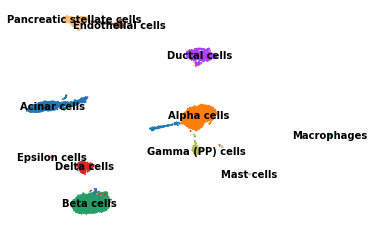

In [6]:
##visualization
ad.obs['Annotation']=np.array(annotation)
sc.pl.umap(ad, color='Annotation', legend_loc='on data', title='', frameon=False)

In [8]:
##compare to author's annotation
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import normalized_mutual_info_score

y = pd.read_csv ('Documents/scRNAseq_Benchmark_datasets/Intra-dataset/Pancreatic_data/Baron_Human/Labels.csv',header=0,index_col=False)
y = y['x'].values

##ARI and NMI
ari = adjusted_rand_score(y,annotation)
print(round(ari,2))
nmi = normalized_mutual_info_score(y,annotation)
print(round(nmi,2))

0.9
0.88
